# Project 3

## Problem Statement

We are a non-profit organisation that provides support to women who are trying to conceive. To some people, it is a difficult journey to take and can be a very stressful period. We routinely share useful articles about women's health, type of diet that prepares the body, and also recommend products that they need. We also have a panel of professionals doctors and counsellors whom they can consult and also host sharing sessions between women to give support to one another. Another group of women that we would like to focus on will be mummies who have experienced a miscarriage. The experience can be traumatizing and some of them maybe overwhelmed by grief. We aim to provide them with proper care physically and mentally and have a smooth transition to join the group who is trying to conceive again. We wish to build a model that enables us to identify this group of women through their messages on various social media platform and reach out to them via advertisements.

## Executive Summary

We first obtain our data from two subreddits, r/TryingToConceive and r/Miscarriage by extracting the json text. In total, we started off with 1754 posts distributed evenly between the two groups. After cleaning the text, the number of posts reduced to 1703 posts with 48.6% belonging to the group r/Miscarriage. We look at some of the text and do a quick analyse of the text before building our model. We tested with using two different transformers (count vectorizer and TFIDF vectorizer) and apply them on four different classifier model to compare with model gave us the best predictions.  The following table shows the results from the various models.

|MODEL|CV R2|Train R2|Test R2|
|---|---|---|---|
|Pipeline Model 1 (Count vectorizer + Logistic Regression)|	0.89292|	0.99835|	0.90403|
|Pipeline Model 1b (TFIDF vectorizer + Logistic Regression)|	0.89950|	0.96128|	0.92706|
|GridSearchCV (Count vectorizer + Logistic Regression)|	0.90115|	0.99835|	0.91171|
|Pipeline Model 2 (Count vectorizer + KNN)|	0.71254|	0.86079|	0.74664|
|Pipeline Model 2b (TFIDF vectorizer + KNN)|	0.83607|	0.90362|	0.85988|
|Pipeline Model 3 (Count vectorizer + SVM)|	0.87974|	0.95057|	0.90211|
|Pipeline Model 3b (TFIDF vectorizer + SVM)|	0.90197|	0.99671|	0.92898|
|GridSearchCV (Count vectorizer + SVM)|	0.88716|	0.95387|	0.91938|
|Pipeline Model 4 (Count vectorizer + Naive Bayes)|	0.89455|	0.94975|	0.91746|
|Pipeline Model 4b (TFIDF vectorizer + Naive Bayes)|	0.87807|	0.93657|	0.90403|
|GridSearchCV (Count vectorizer + Naive Bayes)|	0.90361|	0.93657|	0.92898|


We shortlisted down to two models, which is the Count Vectorizer + SVM and also Count Vectorizer + Naive Bayes, and did evaluation based on them. Indeed, the one with Naive Bayes model gave a higher accuracy in predicting whether women are trying to conceive or experienced a miscarriage. With this model, we are able to identify correctly 91.6% of the posts and target the right advertisements to this group to join our community.

### Contents:
- [1. Gather Data](#1.-Gather-Data)
- [2. Cleaning the Data](#2.-Cleaning-the-Data)
- [3. EDA](#3.-EDA)
- [4. Modelling](#4.-Modelling)
- [5. Model Evalution](#5.-Model-Evalution)
- [6. Key Obervations and Conclusion](#6.-Key-Obervations-and-Conclusion)

### Data Dictionary
|Feature|Datatype|Description|
|:------|:-------|:-----|
|subreddit|object|The subreddit that posts originally belongs to|
|selftext|object|Original text posted by users|
|name|object|unique user name|
|cleantext|object|Cleaned text used for modelling|
|text_len|int|Length of each post|
|label|int|1 for TryingForABay, 0 for Miscarriage|

In [1]:
# Import all relevant libraries

import requests
import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

import regex as re
from bs4 import BeautifulSoup  

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix


## 1. Gather Data

In [2]:
headers = {'User-agent': 'Bingle Bangle'}

In [3]:
# Extracting json text from subreddit r/TryingForABaby

posts = []
after = None
for i in range(35):
    if after == None:
        params = {}
    else:
        params = {'after': after}
        
    url = 'https://www.reddit.com/r/TryingForABaby/.json'
    res = requests.get(url, params=params, headers=headers)
    if res.status_code == 200:
        json_1 = res.json()
        posts.extend(json_1['data']['children'])
        after = json_1['data']['after']
    else:
        print (res.status_code)
        break
    if i%5==0:
        print (i)    
    time.sleep(1)
print ('Done')

0
5
10
15
20
25
30
Done


In [4]:
# Check number of posts obtained
len(set([p['data']['name'] for p in posts]))

877

In [5]:
posts[2]

{'kind': 't3',
 'data': {'approved_at_utc': None,
  'subreddit': 'TryingForABaby',
  'selftext': 'I legitimately don’t understand how people can NTNP. It just feels very black and white to me. You are either trying or avoiding. There is no in between.\n\nI’m only 3 cycles into TTC and I have zero chill. I’m 32 years old and probably a certifiable crazy person. \n\nI’ve got 6 years of cycle data in my Clue app. FAM has been my primary birth control for around 9 years. Since I’ve been acutely aware of my cycle periods for so long I cannot conceive of just not knowing when I was fertile. \n\nI’ve been charting ovulation with OPKs for a year because my cycle got a little messed up after major weight loss. Those little sticks just made me greedy to gather even more data. Plus, i bought the giant box from Amazon so I figured i might as well use them. I broke down and bought a Tempdrop when we officially started trying because I wasn’t fully confident in my manual BBT skills. I’m a neurotic m

In [6]:
# Extracting json from subreddit r/Miscarriage

after = None
for i in range(35):
    if after == None:
        params = {}
    else:
        params = {'after': after}
        
    url = 'https://www.reddit.com/r/Miscarriage/.json'
    res = requests.get(url, params=params, headers=headers)
    if res.status_code == 200:
        json_1 = res.json()
        posts.extend(json_1['data']['children'])
        after = json_1['data']['after']
    else:
        print (res.status_code)
        break
    if i%5==0:
        print (i)    
    time.sleep(1)
print ('Done')

0
5
10
15
20
25
30
Done


In [7]:
# Check total number of posts obtained
len(set([p['data']['name'] for p in posts]))

1754

In [8]:
posts[-2]

{'kind': 't3',
 'data': {'approved_at_utc': None,
  'subreddit': 'Miscarriage',
  'selftext': 'How are you and your partner handling your miscarriage? I love my husband but it’s very difficult for him to understand what I’m going through. He can’t understand the pain, both physical and emotional. The fact that I had something growing inside of me and now it’s dying inside of me. I try to explain it to him but it’s difficult. \n\nI’ll admit I get frustrated and snappy at times. I’ve found myself sitting in my bedroom alone because I just want to be alone. I get angry because he just doesn’t get it. I don’t want to feel or act this way but I do. Anyone else? Hoping I’m not just a bitch haha',
  'author_fullname': 't2_48hxkuf0',
  'saved': False,
  'mod_reason_title': None,
  'gilded': 0,
  'clicked': False,
  'title': 'How is your relationship during this time',
  'link_flair_richtext': [],
  'subreddit_name_prefixed': 'r/Miscarriage',
  'hidden': False,
  'pwls': 0,
  'link_flair_css_cl

In [9]:
# keeping the data portion of json text
posts_data = []
for i in range(len(posts)):
    posts_data.append(posts[i]['data'])

In [10]:
len(posts_data)

1754

In [11]:
# Creating a dataframe to visualize the information
df = pd.DataFrame(posts_data)
df.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,subreddit_subscribers,created_utc,num_crossposts,media,is_video,link_flair_template_id,author_cakeday,url_overridden_by_dest,crosspost_parent_list,crosspost_parent
0,None,TryingForABaby,#Welcome to the Weekly Intro Thread!\n\nHello!...,t2_6l4z3,False,None,0,False,READ ME FIRST! Weekly Intro + Rules Thread Sep...,[],...,59404,1.599391e+09,0,None,False,NaN,NaN,NaN,NaN,NaN
1,None,TryingForABaby,Congratulations on starting a new journey post...,t2_6l4z3,False,None,0,False,"TFAB's Weekly BFP Post - September 06, 2020. G...",[],...,59404,1.599390e+09,0,None,False,NaN,NaN,NaN,NaN,NaN
2,None,TryingForABaby,I legitimately don’t understand how people can...,t2_81l5h4dn,False,None,0,False,I can’t wrap my head around NTNP,[],...,59404,1.599763e+09,0,None,False,b918be88-5273-11e3-88fe-12313b0111fc,NaN,NaN,NaN,NaN
3,None,TryingForABaby,"I know that depo didn't like you, so you went ...",t2_4ex3mduc,False,None,0,False,Listen Aunt Flo,[],...,59404,1.599734e+09,0,None,False,1cd437fe-5274-11e3-819b-12313b0111fc,NaN,NaN,NaN,NaN
4,None,TryingForABaby,"Just a quick lament.. why, just why, does it s...",t2_5eeysmzk,False,None,0,False,F* facebook,[],...,59404,1.599768e+09,0,None,False,b688dbb2-5273-11e3-ad66-12313b079641,NaN,NaN,NaN,NaN


In [12]:
# identifying the columns that we want to keep
wanted = ['subreddit','selftext','name']

In [13]:
train = df[wanted]
train.head()

,subreddit,selftext,name
0,TryingForABaby,#Welcome to the Weekly Intro Thread!\n\nHello!...,t3_ink9tj
1,TryingForABaby,Congratulations on starting a new journey post...,t3_ink9rd
2,TryingForABaby,I legitimately don’t understand how people can...,t3_iq98qu
3,TryingForABaby,"I know that depo didn't like you, so you went ...",t3_iq0qw4
4,TryingForABaby,"Just a quick lament.. why, just why, does it s...",t3_iqb0sg


In [14]:
train.tail()

,subreddit,selftext,name
1749,Miscarriage,I had my first miscarriage (first pregnancy) a...,t3_hn5vm7
1750,Miscarriage,"Hi everyone, I took Misoprostol (3 x 200mcg ta...",t3_hngtny
1751,Miscarriage,I just want to say thank you to anyone who can...,t3_hncokw
1752,Miscarriage,How are you and your partner handling your mis...,t3_hn8oyu
1753,Miscarriage,I found out I was pregnant last Sunday. Honest...,t3_hnbstr


In [15]:
# Checking for duplicates
dup = train.duplicated()
dup.any()

False

In [16]:
# all post are posted by unique users
train['name'].nunique()

1754

In [17]:
# Dropping the first 2 rows as they are welcome messages and rules
train = train.drop([0, 1])

In [18]:
train.shape

(1752, 3)

In [19]:
# Identifying the welcome message
train.iloc[875:878,:]

,subreddit,selftext,name
877,Miscarriage,Please use this thread to talk about how you a...,t3_ijic8w
878,Miscarriage,Please use this thread to discuss how you are ...,t3_iodpz1
879,Miscarriage,My beloved best friend and husband told me and...,t3_iqbjmx


In [20]:
# Dropping the 2 rows of welcome message for r/Miscarriage
train = train.drop([877, 878])

In [21]:
train.shape

(1750, 3)

## 2. Cleaning the Data

In [22]:
# Define a function to clean the selftext

def review_words(raw_text):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    
    # 1. Remove HTML.
    review_text = BeautifulSoup(raw_text).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    
    # 5. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # 5.5 stemming
    p_stemmer = PorterStemmer()
    meaningful_words_stemmed = [p_stemmer.stem(w) for w in meaningful_words]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words_stemmed))

In [23]:
# Initialize an empty list to hold the clean reviews.
clean_text = []
text_len = []

print("Cleaning and parsing subreddit text...")

# Instantiate counter.
j = 0

# For every selftext in our data set...
for train_text in train['selftext']:
    
    # Convert review to words, then append to clean_text.
    clean = review_words(train_text)
    clean_text.append(clean)
    # Count no of words in clean text and append to text_len
    str_len = len(re.findall(r'\w+', clean))
    text_len.append(str_len)
    
    # If the index is divisible by 100, print a message.
    if (j + 1) % 100 == 0:
        print(f'Reviewed {j + 1} text...')
    
    j += 1
print ('Done.')

Cleaning and parsing subreddit text...
Reviewed 100 text...
Reviewed 200 text...
Reviewed 300 text...
Reviewed 400 text...
Reviewed 500 text...
Reviewed 600 text...
Reviewed 700 text...
Reviewed 800 text...
Reviewed 900 text...
Reviewed 1000 text...
Reviewed 1100 text...
Reviewed 1200 text...
Reviewed 1300 text...
Reviewed 1400 text...
Reviewed 1500 text...
Reviewed 1600 text...
Reviewed 1700 text...
Done.


In [24]:
clean_text[2]

'quick lament seem like contact facebook babi know patient stress ugh sting see everyon babi'

In [25]:
train['selftext'][4]

'Just a quick lament.. why, just why, does it seem like all my contacts on Facebook have babies? I know I have to be patient and not stress but, ugh! Such a sting when I see everyone and their baby.'

In [26]:
text_len[:10]

[115, 31, 15, 110, 126, 148, 26, 12, 19, 57]

In [27]:
# adding two additional columns to dataframe to store the clean text and also length of text
train['cleantext'] = clean_text
train['text_len'] = text_len

In [28]:
train.head()

,subreddit,selftext,name,cleantext,text_len
2,TryingForABaby,I legitimately don’t understand how people can...,t3_iq98qu,legitim understand peopl ntnp feel black white...,115
3,TryingForABaby,"I know that depo didn't like you, so you went ...",t3_iq0qw4,know depo like went away whilst around know he...,31
4,TryingForABaby,"Just a quick lament.. why, just why, does it s...",t3_iqb0sg,quick lament seem like contact facebook babi k...,15
5,TryingForABaby,When we started our journey in January I hoped...,t3_iqe51j,start journey januari hope get lucki septemb b...,110
6,TryingForABaby,I’ve posted once before about the confusing in...,t3_iq6bcj,post confus inform receiv fertil clinic amh le...,126


In [29]:
train[train['text_len']==0]

,subreddit,selftext,name,cleantext,text_len
933,Miscarriage,,t3_ioapbs,,0
1088,Miscarriage,,t3_ihladc,,0
1105,Miscarriage,,t3_ih2pnn,,0
1144,Miscarriage,,t3_ifg5nc,,0
1262,Miscarriage,,t3_iar1j4,,0
1296,Miscarriage,,t3_i8ugks,,0
1435,Miscarriage,,t3_i1984o,,0
1463,Miscarriage,,t3_i0i9aq,,0
1491,Miscarriage,I,t3_hzmr14,,0
1528,Miscarriage,I,t3_hxsea4,,0


In [30]:
# Dropping all rows with no text
train.drop(train[train['text_len'] == 0].index, inplace=True)

In [31]:
train.shape

(1735, 5)

In [32]:
# Looking for other rows with duplicated text
train[train['text_len']<8]

,subreddit,selftext,name,cleantext,text_len
19,TryingForABaby,Wondering if it’s worth the money,t3_iqbahn,wonder worth money,3
65,TryingForABaby,Are you in the dreaded two-week wait? What hav...,t3_iphnb8,dread two week wait done eas stress,7
99,TryingForABaby,Any supplement recommendations to help conceive?,t3_iph7vd,supplement recommend help conceiv,4
189,TryingForABaby,Why? What would cause this?,t3_iock7f,would caus,2
212,TryingForABaby,Basically the title. How many DPO would you st...,t3_inuom7,basic titl mani dpo would start test,7
224,TryingForABaby,"I need someone to celebrate with, my IUD is ou...",t3_ing8fk,need someon celebr iud,4
266,TryingForABaby,Any kinds that you prefer?,t3_inbnuy,kind prefer,2
365,TryingForABaby,It both burns and probably ruined O day 🤣🤦🏻‍♀️,t3_ilbhk3,burn probabl ruin day,4
384,TryingForABaby,Are you in the dreaded two-week wait? What hav...,t3_il8iut,dread two week wait done eas stress,7
393,TryingForABaby,"If so, how soon after ovulation would it typic...",t3_ilaf8v,soon ovul would typic happen long test,7


In [33]:
# Dropping all rows with generic and meaningless text
train.drop(train[train['cleantext'] == 'place discuss anyth relat relat miscarriag'].index, inplace=True)
train.drop(train[train['cleantext'] == 'dread two week wait done eas stres'].index, inplace=True)

In [34]:
train[train['text_len']<8]

,subreddit,selftext,name,cleantext,text_len
19,TryingForABaby,Wondering if it’s worth the money,t3_iqbahn,wonder worth money,3
65,TryingForABaby,Are you in the dreaded two-week wait? What hav...,t3_iphnb8,dread two week wait done eas stress,7
99,TryingForABaby,Any supplement recommendations to help conceive?,t3_iph7vd,supplement recommend help conceiv,4
189,TryingForABaby,Why? What would cause this?,t3_iock7f,would caus,2
212,TryingForABaby,Basically the title. How many DPO would you st...,t3_inuom7,basic titl mani dpo would start test,7
224,TryingForABaby,"I need someone to celebrate with, my IUD is ou...",t3_ing8fk,need someon celebr iud,4
266,TryingForABaby,Any kinds that you prefer?,t3_inbnuy,kind prefer,2
365,TryingForABaby,It both burns and probably ruined O day 🤣🤦🏻‍♀️,t3_ilbhk3,burn probabl ruin day,4
384,TryingForABaby,Are you in the dreaded two-week wait? What hav...,t3_il8iut,dread two week wait done eas stress,7
393,TryingForABaby,"If so, how soon after ovulation would it typic...",t3_ilaf8v,soon ovul would typic happen long test,7


In [35]:
# remaing posts in each category
train['subreddit'].value_counts()

TryingForABaby    875
Miscarriage       828
Name: subreddit, dtype: int64

## 3. EDA

In [36]:
train[train['subreddit']=='TryingForABaby']['text_len'].describe()

count    875.000000
mean      64.374857
std       69.949369
min        2.000000
25%       27.000000
50%       48.000000
75%       80.000000
max      815.000000
Name: text_len, dtype: float64

In [37]:
train[train['subreddit']=='Miscarriage']['text_len'].describe()

count     828.000000
mean       97.504831
std       107.229252
min         1.000000
25%        38.750000
50%        67.000000
75%       114.250000
max      1237.000000
Name: text_len, dtype: float64

In [38]:
# Define a function to plot the frequency distribution of a feature and showing its mean value on the same graph.

def plot_hist(df, feature):
    mean = df[feature].mean()
    plt.figure(figsize=(12,8))
    
    # mean will be displaced as a dotted red line
    plt.axvline(x=mean,c='r',ls='--')
    plt.text(mean,0,'Mean',c='r',size=15)
    
    # plot of frequency distribution using seaborn
    sns.distplot(df[feature]);
    plt.title('Frequency Distribution of {}'.format(feature), {'fontsize': 20})

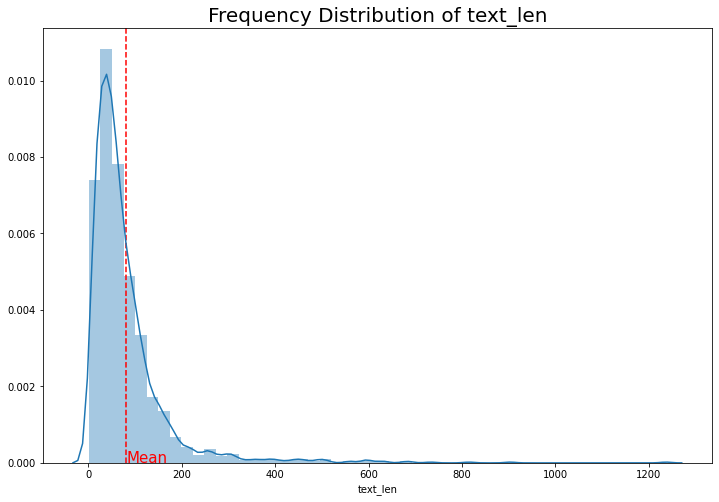

In [39]:
plot_hist(train, 'text_len')

<AxesSubplot:xlabel='subreddit', ylabel='text_len'>

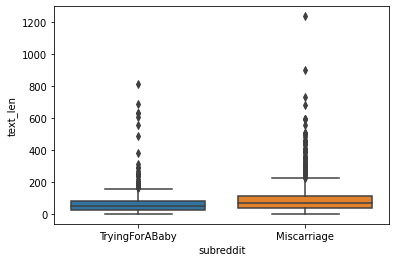

In [40]:
sns.boxplot(x="subreddit", y="text_len", data=train)

For the subreddit 'TryingForABaby', the mean length of text after cleaning is 69 words, whereas for the subreddit 'Miscarriage', the mean length of text is 99 words. The average length of posts for r/'Miscarriage' is longer and for both categories, there are some outliers posts with much higher numbers of words in their text.

In [41]:
# Define a function to generate wordcloud

def gen_wordcloud(df, col):

    # Create and generate a word cloud image:
    wordcloud = WordCloud(colormap='PiYG').generate(' '.join(df[col]))

    # Display the generated image:
    plt.figure(figsize=(8,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

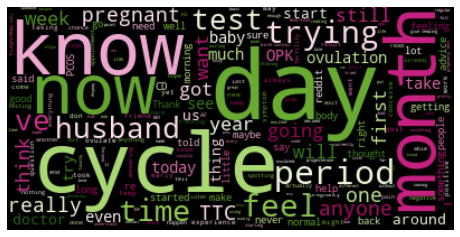

In [42]:
train_trying = train.loc[train['subreddit']=='TryingForABaby']
gen_wordcloud(train_trying, 'selftext')

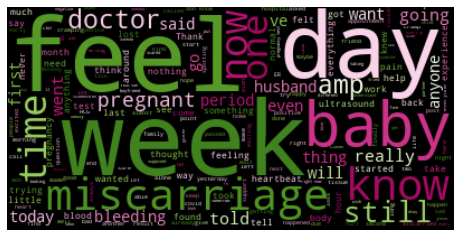

In [43]:
train_trying = train.loc[train['subreddit']=='Miscarriage']
gen_wordcloud(train_trying, 'selftext')

For r/'TryingForABaby', the key words are 'cycle','know','day','month','period','husband' and 'TTC'.
For r/'Miscarriage', the key words are 'feel','baby','week','day'
'day' seems to be quite common in both subreddits.

In [44]:
# Label TryingForABaby as 1 and Miscarriage as 0.
train['label'] = train['subreddit'].map({'TryingForABaby': 1, 'Miscarriage': 0})
train.head()

,subreddit,selftext,name,cleantext,text_len,label
2,TryingForABaby,I legitimately don’t understand how people can...,t3_iq98qu,legitim understand peopl ntnp feel black white...,115,1
3,TryingForABaby,"I know that depo didn't like you, so you went ...",t3_iq0qw4,know depo like went away whilst around know he...,31,1
4,TryingForABaby,"Just a quick lament.. why, just why, does it s...",t3_iqb0sg,quick lament seem like contact facebook babi k...,15,1
5,TryingForABaby,When we started our journey in January I hoped...,t3_iqe51j,start journey januari hope get lucki septemb b...,110,1
6,TryingForABaby,I’ve posted once before about the confusing in...,t3_iq6bcj,post confus inform receiv fertil clinic amh le...,126,1


In [45]:
train.tail()

,subreddit,selftext,name,cleantext,text_len,label
1749,Miscarriage,I had my first miscarriage (first pregnancy) a...,t3_hn5vm7,first miscarriag first pregnanc begin june wee...,102,0
1750,Miscarriage,"Hi everyone, I took Misoprostol (3 x 200mcg ta...",t3_hngtny,hi everyon took misoprostol x mcg tab sublingu...,57,0
1751,Miscarriage,I just want to say thank you to anyone who can...,t3_hncokw,want say thank anyon help month ago girlfriend...,70,0
1752,Miscarriage,How are you and your partner handling your mis...,t3_hn8oyu,partner handl miscarriag love husband difficul...,44,0
1753,Miscarriage,I found out I was pregnant last Sunday. Honest...,t3_hnbstr,found pregnant last sunday honestli tell inspi...,228,0


In [46]:
train.to_csv('datasets/train.csv')

## 4. Modelling

In [47]:
# Setting up data

X = train['cleantext']
y = train['label']

In [48]:
# Checking the baseline accuracy
y.value_counts(normalize=True)

1    0.513799
0    0.486201
Name: label, dtype: float64

In [49]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)

In [50]:
X_train.shape

(1192,)

In [51]:
X_test.shape

(511,)

In [52]:
y_test.value_counts(normalize=True)

1    0.514677
0    0.485323
Name: label, dtype: float64

### Pipeline Model 1 (Count vectorizer + Logistic Regression)

In [53]:
# Set up a pipeline to run CountVectorizer ad LogisticRegression
pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver='lbfgs'))
])

In [54]:
cross_val_score(pipe1, X_train, y_train, cv=5).mean()

0.8909602334657712

In [55]:
# Fit and score model
pipe1.fit(X_train, y_train)
pipe1.score(X_train,y_train)

0.9983221476510067

In [56]:
pipe1.score(X_test,y_test)

0.9158512720156555

###  Model 1b (TFIDF vectorizer + Logistic Regression)

In [57]:
pipe1b = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(solver='lbfgs'))
])

In [58]:
pipe1b.fit(X_train, y_train)

# Evaluate logistic regression.
print(f'CV Score: {cross_val_score(pipe1b, X_train, y_train, cv=5).mean()}')
print(f'Training Score: {pipe1b.score(X_train, y_train)}')
print(f'Testing Score: {pipe1b.score(X_test, y_test)}')

CV Score: 0.907731795647129
Training Score: 0.9664429530201343
Testing Score: 0.9080234833659491


### Using GridSearchCV (Count vectorizer + Logistic Regression)

In [59]:
pipe1.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('lr', LogisticRegression())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'lr': LogisticRegression(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': None,
 'lr__solver': 'lbfgs',
 'lr__tol': 0.0001,
 'lr__verbose': 0,
 'lr__warm_start': False}

In [60]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 3000, 4000
# Minimum number of documents needed to include token: 2, 3, 4
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features': [3000, 4000, 5000],
    'cvec__min_df': [2,3,4],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1,1),(1,2),(1,3)]
}

In [61]:
# Instantiate GridSearchCV.

gs1 = GridSearchCV(pipe1, param_grid = pipe_params, cv=5) 

In [62]:
# Fit GridSearch to training data.
gs1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [3000, 4000, 5000],
                         'cvec__min_df': [2, 3, 4],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)]})

In [63]:
gs1.best_score_

0.8934812418691326

In [64]:
gs1.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 3)}

In [65]:
# Save best model as gs_model.
gs_best1 = gs1.best_estimator_

In [66]:
# Fit and Score model
gs_best1.fit(X_train,y_train)
gs_best1.score(X_train, y_train)

0.9983221476510067

In [67]:
gs_best1.score(X_test, y_test)

0.9275929549902152

### Pipeline Model 2 (Count vectorizer + KNN)

In [68]:
# Set up a pipeline to run CountVectorizer ad KNN
pipe2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [69]:
pipe2.fit(X_train,y_train)
pipe2.score(X_train,y_train)

0.8053691275167785

In [70]:
pipe2.score(X_test,y_test)

0.684931506849315

In [71]:
cross_val_score(pipe2, X_train, y_train, cv=5).mean()

0.7097043001300938

### Pipeline Model 2b (TFIDF Vectorizer + KNN)

In [72]:
pipe2b = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [73]:
pipe2b.fit(X_train, y_train)

# Evaluate logistic regression.
print(f'CV Score: {cross_val_score(pipe2b, X_train, y_train, cv=5).mean()}')
print(f'Training Score: {pipe2b.score(X_train, y_train)}')
print(f'Testing Score: {pipe2b.score(X_test, y_test)}')

CV Score: 0.8507084842305123
Training Score: 0.9052013422818792
Testing Score: 0.8414872798434442


### Pipeline Model 3 (Count vectorizer + SVM)

In [74]:
# Set up a pipeline to run CountVectorizer ad SVM
pipe3 = Pipeline([
    ('cvec', CountVectorizer()),
    ('svm', SVC())
])

In [75]:
pipe3.fit(X_train,y_train)
pipe3.score(X_train,y_train)

0.9546979865771812

In [76]:
pipe3.score(X_test,y_test)

0.8943248532289628

In [77]:
cross_val_score(pipe3, X_train, y_train, cv=5).mean()

0.8750079111142366

### Pipeline Model 3b (TFIDF vectorizer + SVM)

In [78]:
pipe3b = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svm', SVC())
])

In [79]:
pipe3b.fit(X_train, y_train)

# Evaluate logistic regression.
print(f'CV Score: {cross_val_score(pipe3b, X_train, y_train, cv=5).mean()}')
print(f'Training Score: {pipe3b.score(X_train, y_train)}')
print(f'Testing Score: {pipe3b.score(X_test, y_test)}')

CV Score: 0.9110931401849441
Training Score: 0.99748322147651
Testing Score: 0.9158512720156555


### Using GridSearchCV (Count vectorizer + SVM)

In [80]:
pipe3.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('svm', SVC())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'svm': SVC(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'svm__C': 1.0,
 'svm__break_ties': False,
 'svm__cache_size': 200,
 'svm__class_weight': None,
 'svm__coef0': 0.0,
 'svm__decision_function_shape': 'ovr',
 'svm__degree': 3,
 'svm__gamma': 'scale',
 'svm__kernel': 'rbf',
 'svm__max_iter': -1,
 'svm__probability': False,
 'svm__random_state': None,
 'svm__shrinking': True,
 'svm__tol': 0.001,
 'svm__verbose': False}

In [81]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 1000, 2000, 3000
# Minimum number of documents needed to include token: 2, 3, 4
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features': [1000, 2000, 3000],
    'cvec__min_df': [2,3,4],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1,1),(1,2),(1,3)],
}

In [82]:
gs3 = GridSearchCV(pipe3, param_grid = pipe_params, cv=5) 

In [83]:
# Fit GridSearch to training data.
gs3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('svm', SVC())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [1000, 2000, 3000],
                         'cvec__min_df': [2, 3, 4],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)]})

In [84]:
gs3.best_score_

0.8808937801061848

In [85]:
gs3.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 3)}

In [86]:
# Save best model as gs_model.
gs_best3 = gs3.best_estimator_

In [87]:
# Fit and Score model
gs_best3.fit(X_train,y_train)
gs_best3.score(X_train, y_train)

0.9563758389261745

In [88]:
gs_best3.score(X_test,y_test)

0.898238747553816

### Pipeline Model 4 (Count vectorizer + Naive Bayes)

In [89]:
# Set up a pipeline to run CountVectorizer ad Naive Bayes
pipe4 = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [90]:
pipe4.fit(X_train,y_train)
pipe4.score(X_train,y_train)

0.9496644295302014

In [91]:
pipe4.score(X_test,y_test)

0.9119373776908023

In [92]:
cross_val_score(pipe4, X_train, y_train, cv=5).mean()

0.8892795611968637

### Pipeline Model 4b (TFIDF vectorizer + Naive Bayes)

In [93]:
pipe4b = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [94]:
pipe4b.fit(X_train, y_train)

# Evaluate logistic regression.
print(f'CV Score: {cross_val_score(pipe4b, X_train, y_train, cv=5).mean()}')
print(f'Training Score: {pipe4b.score(X_train, y_train)}')
print(f'Testing Score: {pipe4b.score(X_test, y_test)}')

CV Score: 0.883428852712633
Training Score: 0.9412751677852349
Testing Score: 0.8884540117416829


### Using GridSearchCV (Count vectorizer + Naive Bayes)

In [95]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 1000, 2000, 3000
# Minimum number of documents needed to include token: 2, 3, 4
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features': [1000, 2000, 3000],
    'cvec__min_df': [2,3,4],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1,1),(1,2),(1,3)],
}

In [96]:
gs4 = GridSearchCV(pipe4, param_grid = pipe_params, cv=5) 

In [97]:
# Fit GridSearch to training data.
gs4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [1000, 2000, 3000],
                         'cvec__min_df': [2, 3, 4],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)]})

In [98]:
gs4.best_score_

0.9002074469955346

In [99]:
gs4.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 4,
 'cvec__ngram_range': (1, 2)}

In [100]:
# Save best model as gs_model.
gs_best4 = gs4.best_estimator_

In [101]:
# Fit and Score model
gs_best4.fit(X_train,y_train)
gs_best4.score(X_train, y_train)

0.947986577181208

In [102]:
gs_best4.score(X_test,y_test)

0.9178082191780822

### Summary

|MODEL|CV R2|Train R2|Test R2|
|---|---|---|---|
|Pipeline Model 1 (Count vectorizer + Logistic Regression)|	0.89292|	0.99835|	0.90403|
|Pipeline Model 1b (TFIDF vectorizer + Logistic Regression)|	0.89950|	0.96128|	0.92706|
|GridSearchCV (Count vectorizer + Logistic Regression)|	0.90115|	0.99835|	0.91171|
|Pipeline Model 2 (Count vectorizer + KNN)|	0.71254|	0.86079|	0.74664|
|Pipeline Model 2b (TFIDF vectorizer + KNN)|	0.83607|	0.90362|	0.85988|
|Pipeline Model 3 (Count vectorizer + SVM)|	0.87974|	0.95057|	0.90211|
|Pipeline Model 3b (TFIDF vectorizer + SVM)|	0.90197|	0.99671|	0.92898|
|GridSearchCV (Count vectorizer + SVM)|	0.88716|	0.95387|	0.91938|
|Pipeline Model 4 (Count vectorizer + Naive Bayes)|	0.89455|	0.94975|	0.91746|
|Pipeline Model 4b (TFIDF vectorizer + Naive Bayes)|	0.87807|	0.93657|	0.90403|
|GridSearchCV (Count vectorizer + Naive Bayes)|	0.90361|	0.93657|	0.92898|

For logistic regression and KNN Classifier, the R2 score for the train and test data set seems to have a great difference, meaning that the model is overfitting. After we tried using SVM, the difference became less. A gridsearch shows that these parameters work better: 
- 'cvec__max_df': 0.9
- 'cvec__max_features': 3000
- 'cvec__min_df': 2
- 'cvec__ngram_range': (1, 3)

Comparing this with Naive Bayes model, Naive Bayes is performing better as compared to SVM in this case, with the following parameters:
- 'cvec__max_df': 0.9
- 'cvec__max_features': 2000
- 'cvec__min_df': 4
- 'cvec__ngram_range': (1, 2)

There is even less overfitting with a higher mean score using cross validation.

We will evaluate the 2 models above.

## 5. Model Evalution

### Confusion Matrix for Count vectorizer + SVM Model

In [103]:
pred_3 = gs_best3.predict(X_test)
pred_3[:10]

array([1, 0, 1, 0, 0, 0, 1, 1, 1, 0])

In [104]:
cm1 = confusion_matrix(y_test, pred_3)
cm1

array([[221,  27],
       [ 25, 238]])

In [105]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_3).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 221
False Positives: 27
False Negatives: 25
True Positives: 238


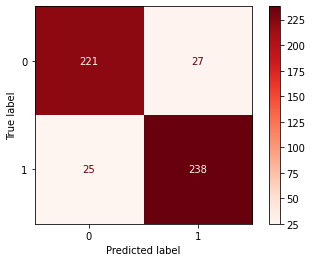

In [106]:
# Plotting the confusion matrix
plot_confusion_matrix(gs_best3, X_test, y_test, cmap='Reds')

In [107]:
# Evaluation metrics
print (f'accuracy: {(tp+tn)/(tn+fp+fn+tp)}')
print (f'sensitivity: {tp/(tp+fn)}')
print (f'specificity: {tn/(tn+fp)}')
print (f'precision: {tp/(tp+fp)}')

accuracy: 0.898238747553816
sensitivity: 0.9049429657794676
specificity: 0.8911290322580645
precision: 0.8981132075471698


### Confusion Matrix for Count vectorizer + Naive Bayes Model

In [108]:
pred_4 = gs_best4.predict(X_test)
pred_4[:10]

array([1, 0, 1, 0, 0, 0, 1, 1, 1, 0])

In [109]:
cm2 = confusion_matrix(y_test, pred_4)
cm2

array([[238,  10],
       [ 32, 231]])

In [110]:
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, pred_4).ravel()
print("True Negatives: %s" % tn2)
print("False Positives: %s" % fp2)
print("False Negatives: %s" % fn2)
print("True Positives: %s" % tp2)

True Negatives: 238
False Positives: 10
False Negatives: 32
True Positives: 231


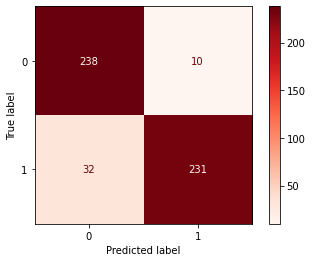

In [111]:
# Plotting the confusion matrix
plot_confusion_matrix(gs_best4, X_test, y_test, cmap='Reds')

In [112]:
# Showing the evaulation metrics
print (f'accuracy: {(tp2+tn2)/(tn2+fp2+fn2+tp2)}')
print (f'sensitivity: {tp2/(tp2+fn2)}')
print (f'specificity: {tn2/(tn2+fp2)}')
print (f'precision: {tp2/(tp2+fp2)}')

accuracy: 0.9178082191780822
sensitivity: 0.8783269961977186
specificity: 0.9596774193548387
precision: 0.9585062240663901


### Analyzing the words with highest frequency

In [113]:
train.head()

,subreddit,selftext,name,cleantext,text_len,label
2,TryingForABaby,I legitimately don’t understand how people can...,t3_iq98qu,legitim understand peopl ntnp feel black white...,115,1
3,TryingForABaby,"I know that depo didn't like you, so you went ...",t3_iq0qw4,know depo like went away whilst around know he...,31,1
4,TryingForABaby,"Just a quick lament.. why, just why, does it s...",t3_iqb0sg,quick lament seem like contact facebook babi k...,15,1
5,TryingForABaby,When we started our journey in January I hoped...,t3_iqe51j,start journey januari hope get lucki septemb b...,110,1
6,TryingForABaby,I’ve posted once before about the confusing in...,t3_iq6bcj,post confus inform receiv fertil clinic amh le...,126,1


In [114]:
# extracting cleantext for r/TryingForABaby
trying = train.loc[train['subreddit']=='TryingForABaby','cleantext']
trying.head()

2    legitim understand peopl ntnp feel black white...
3    know depo like went away whilst around know he...
4    quick lament seem like contact facebook babi k...
5    start journey januari hope get lucki septemb b...
6    post confus inform receiv fertil clinic amh le...
Name: cleantext, dtype: object

In [115]:
# extracting cleantext for r/Miscarriage
miscarriage = train.loc[train['subreddit']=='Miscarriage','cleantext']
miscarriage.head()

879    belov best friend husband told husband expect ...
880    best friend sinc childhood like sister found p...
881    hi new chemic pregnanc januari anoth chemic pr...
882    suppos week accord last period think nearer we...
883    second mmc year fuck life last one c sign blee...
Name: cleantext, dtype: object

In [116]:
try_vec = CountVectorizer(max_df=0.9, max_features=2000, min_df=4, ngram_range=(1, 2))

In [117]:
try_features = try_vec.fit_transform(trying)

In [118]:
# Creating a dataframe for count vectorizer
try_features_df = pd.DataFrame(try_features.toarray(), columns=try_vec.get_feature_names())
try_features_df.head()

,abil,abl,abl get,abnorm,absolut,accept,accord,account,accur,acid,...,year old,year recent,year sinc,year tri,year ttc,yesterday,yesterday today,yet,young,youtub
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [119]:
# Identifying top 20 words from r/TryingForABaby
try_top = try_features_df.sum().sort_values().tail(20)
try_top

year        310
ttc         324
first       328
would       342
pregnant    348
want        379
go          380
time        404
period      405
start       449
ovul        493
feel        493
know        497
like        520
month       552
test        557
tri         637
cycl        653
get         666
day         853
dtype: int64

In [120]:
mis_vec = CountVectorizer(max_df=0.9, max_features=2000, min_df=4, ngram_range=(1, 2))
mis_features = mis_vec.fit_transform(miscarriage)

In [121]:
mis_features_df = pd.DataFrame(mis_features.toarray(), columns=mis_vec.get_feature_names())
mis_features_df.head()

,abdomin,abl,abl get,abnorm,abort,absolut,abus,accept,accord,account,...,year ago,year old,yell,yesterday,yesterday start,yet,yolk,yolk sac,young,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,1,0,0
3,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0


In [122]:
# Identifying top 20 words from r/Miscarriage
mis_top = mis_features_df.sum().sort_values().tail(20)
mis_top

still          434
test           462
pregnant       463
tri            465
would          511
bleed          513
first          532
time           544
start          548
pregnanc       584
want           604
miscarriag     657
babi           667
get            675
know           727
go             740
day            854
like           869
feel          1060
week          1141
dtype: int64

In [123]:
type(mis_top)

pandas.core.series.Series

<AxesSubplot:>

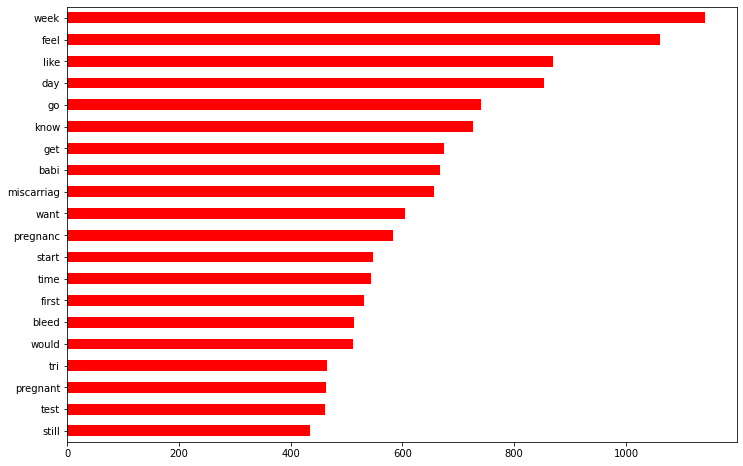

In [124]:
# Plotting the top 20 words for r/Miscarriage
plt.figure(figsize=(12,8))
mis_top.plot.barh(rot=0, color='red')

<AxesSubplot:>

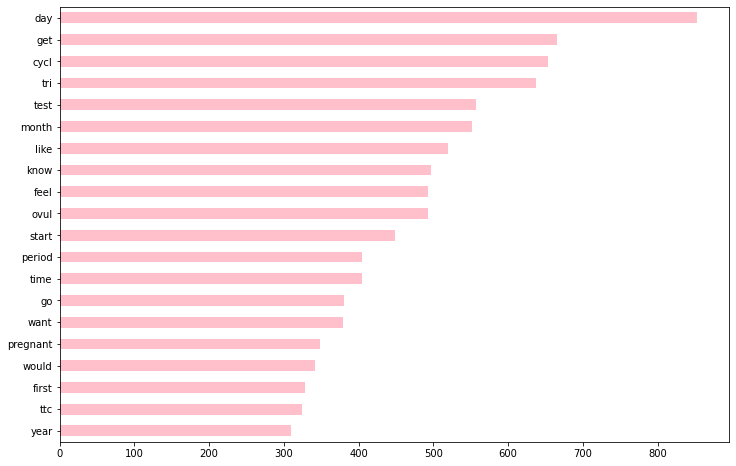

In [125]:
# Plotting the top 20 words for r/TryingForABaby
plt.figure(figsize=(12,8))
try_top.plot.barh(rot=0, color='pink')

About 60% of the top 2000 words actually appears in both subreddits. Even in the top 20 words, more than half of them are overlapping but with different level of occurence. 

In [126]:
mis_features_df.shape

(828, 2000)

In [127]:
mis_features_df.columns

Index(['abdomin', 'abl', 'abl get', 'abnorm', 'abort', 'absolut', 'abus',
       'accept', 'accord', 'account',
       ...
       'year ago', 'year old', 'yell', 'yesterday', 'yesterday start', 'yet',
       'yolk', 'yolk sac', 'young', 'zero'],
      dtype='object', length=2000)

In [128]:
try_features_df.shape

(875, 2000)

In [129]:
try_features_df.columns

Index(['abil', 'abl', 'abl get', 'abnorm', 'absolut', 'accept', 'accord',
       'account', 'accur', 'acid',
       ...
       'year old', 'year recent', 'year sinc', 'year tri', 'year ttc',
       'yesterday', 'yesterday today', 'yet', 'young', 'youtub'],
      dtype='object', length=2000)

In [130]:
common = set(mis_features_df.columns)&set(try_features_df.columns)
len(common)

1194

In [131]:
X_test.head()

11      hope iui near end august bfp present wife toda...
1617    best friend surpris babi shower two week organ...
232     hi husband bare begun discuss idea get pregnan...
1595    today boyfriend friend wife babi shower due we...
1285    last period may miss two period found pregnant...
Name: cleantext, dtype: object

In [132]:
y_test.head()

11      1
1617    0
232     1
1595    0
1285    0
Name: label, dtype: int64

In [133]:
pred_4[:5]

array([1, 0, 1, 0, 0])

In [134]:
test_text = X_test.to_frame()
test_text.head()

,cleantext
11,hope iui near end august bfp present wife toda...
1617,best friend surpris babi shower two week organ...
232,hi husband bare begun discuss idea get pregnan...
1595,today boyfriend friend wife babi shower due we...
1285,last period may miss two period found pregnant...


In [135]:
test_y = y_test.to_frame()
test_y.head()

,label
11,1
1617,0
232,1
1595,0
1285,0


In [136]:
test_df = pd.concat([test_text, test_y], axis=1)
test_df.head()

,cleantext,label
11,hope iui near end august bfp present wife toda...,1
1617,best friend surpris babi shower two week organ...,0
232,hi husband bare begun discuss idea get pregnan...,1
1595,today boyfriend friend wife babi shower due we...,0
1285,last period may miss two period found pregnant...,0


In [137]:
test_df['pred'] = pred_4
test_df.head()

,cleantext,label,pred
11,hope iui near end august bfp present wife toda...,1,1
1617,best friend surpris babi shower two week organ...,0,0
232,hi husband bare begun discuss idea get pregnan...,1,1
1595,today boyfriend friend wife babi shower due we...,0,0
1285,last period may miss two period found pregnant...,0,0


In [138]:
false_positives = test_df[(test_df['label']!=test_df['pred']) & (test_df['pred']==1)]
false_positives.shape

(10, 3)

In [139]:
false_positives.index

Int64Index([1006, 1056, 1731, 974, 1552, 1284, 1087, 1032, 1672, 1623], dtype='int64')

In [140]:
false_positives.head()

,cleantext,label,pred
1006,long vent warn mmc week c week ago time partic...,0,1
1056,anyon recommend pill vitamin miner tip mc,0,1
1731,tomorrow get tattoo miscarriag decid get mount...,0,1
974,miscarriag string art http imgur com galleri icf,0,1
1552,alway kept journal yesterday start new section...,0,1


In [141]:
fp_selftext = train[train.index.isin(false_positives.index)]['selftext'].to_frame()
fp_selftext.head()

,selftext
974,[miscarriage string art ](https://imgur.com/ga...
1006,Long vent warning. \nHad a MMC at 9 weeks and ...
1032,I have had a MC and wanted to know how long it...
1056,Can anyone recommend any pills/ vitamins/ mine...
1087,I guess the title explains it all. It's disapp...


In [142]:
false_positives = pd.concat([false_positives, fp_selftext], axis=1)
false_positives.head()

,cleantext,label,pred,selftext
974,miscarriag string art http imgur com galleri icf,0,1,[miscarriage string art ](https://imgur.com/ga...
1006,long vent warn mmc week c week ago time partic...,0,1,Long vent warning. \nHad a MMC at 9 weeks and ...
1032,mc want know long take longer test posit,0,1,I have had a MC and wanted to know how long it...
1056,anyon recommend pill vitamin miner tip mc,0,1,Can anyone recommend any pills/ vitamins/ mine...
1087,guess titl explain disappoint babi shower atte...,0,1,I guess the title explains it all. It's disapp...


In [143]:
fp_text = false_positives['selftext'].to_list()

In [144]:
fp_text[3]

'Can anyone recommend any pills/ vitamins/ minerals/ tips after a MC?'

In [145]:
false_positives.to_csv('datasets/false_positives.csv')

In [146]:
false_negatives = test_df[(test_df['label']!=test_df['pred']) & (test_df['pred']==0)]
false_negatives.shape

(32, 3)

In [147]:
fn_selftext = train[train.index.isin(false_negatives.index)]['selftext'].to_frame()
fn_selftext.head()

,selftext
4,"Just a quick lament.. why, just why, does it s..."
24,I'll leave my background information related t...
114,Hi all! I wanted to take a moment (edit: or no...
250,Does anyone else struggle with their sibling’s...
321,I am experiencing my first early miscarriage a...


In [148]:
false_negatives = pd.concat([false_negatives, fn_selftext], axis=1)
false_negatives.head()

,cleantext,label,pred,selftext
4,quick lament seem like contact facebook babi k...,1,0,"Just a quick lament.. why, just why, does it s..."
24,leav background inform relat actual get test h...,1,0,I'll leave my background information related t...
114,hi want take moment edit end realli long post ...,1,0,Hi all! I wanted to take a moment (edit: or no...
250,anyon els struggl sibl partner relationship mo...,1,0,Does anyone else struggle with their sibling’s...
321,experienc first earli miscarriag found due low...,1,0,I am experiencing my first early miscarriage a...


In [149]:
false_negatives.to_csv('datasets/false_negatives.csv')

In [150]:
false_results = pd.concat([false_positives, false_negatives])

In [151]:
false_results.shape

(42, 4)

In [152]:
miscarriage_words = mis_features_df.columns.to_list()

In [153]:
trying_words = try_features_df.columns.to_list()
len(trying_words)

2000

In [154]:
false_results.head()

,cleantext,label,pred,selftext
974,miscarriag string art http imgur com galleri icf,0,1,[miscarriage string art ](https://imgur.com/ga...
1006,long vent warn mmc week c week ago time partic...,0,1,Long vent warning. \nHad a MMC at 9 weeks and ...
1032,mc want know long take longer test posit,0,1,I have had a MC and wanted to know how long it...
1056,anyon recommend pill vitamin miner tip mc,0,1,Can anyone recommend any pills/ vitamins/ mine...
1087,guess titl explain disappoint babi shower atte...,0,1,I guess the title explains it all. It's disapp...


In [155]:
# Define a function to return top 2000 words in tryingforababy or miscarriage subreddit
def common_words(df, index):
    if df.loc[index,'label'] == 1:
        print ('This text is a false negative. It is actually a post in r/TryingForABaby.')
    else:
        print ('This text is a false positive. It is actually a post in r/Miscarriage.')
    
    print ('\nOriginal text:\n')
    print ('{}'.format(df.loc[index,'selftext']))
    
    print ('\nList of top common words in Miscarriage subreddit:\n')
    mis_common = list(set(miscarriage_words) & set(df.loc[index,'cleantext'].split(" ")))
    print (mis_common)
    
    print ('\nList of top common words in TryingForABaby subreddit:\n')
    try_common = list(set(trying_words) & set(df.loc[index,'cleantext'].split(" ")))
    print (try_common)
    
    common = list(set(try_common) & set(mis_common))

In [163]:
common_words(false_results, false_results.index[2])

This text is a false positive. It is actually a post in r/Miscarriage.

Original text:

I have had a MC and wanted to know how long it will take to no longer test positive?

List of top common words in Miscarriage subreddit:

['long', 'longer', 'want', 'know', 'posit', 'test', 'mc', 'take']

List of top common words in TryingForABaby subreddit:

['long', 'longer', 'want', 'know', 'posit', 'test', 'mc', 'take']


When we checked the misclassified text, it was found that these posts contained most words that are overlapping. They got misclassified because they also contains certain words that occurs very frequently which belongs to the other group. As the conditional probability of these words are high, they affected the classification outcome.

## 6. Key Obervations and Conclusion

By using the count vectorizer + Naive Bayes model, we are able to get an accuracy of 91.5% which is performing well given that the nature of the two subreddit topics are very close to each other. In fact, it was found that around 60% of the words are common in both topics but different weightage. To further improve the model, we can analyse the common words found in both groups and create a meaningful list of stopwords instead of using the common stopwords, and run the various models again. 

For the group that was identified as r/Miscarriage on different social media platforms, we will run target advertisements to spread awareness about our support group and community. With this, we wish to be able to reach out to more women who can share their journey together and be able to reduce the stress that they might experienced alone. 